In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import cv2
import os
import PIL
import random
import SimpleITK as sitk
from albumentations.pytorch import ToTensorV2
import albumentations as A
# Set the path to the file you'd like to load
file_path = "/kaggle/input/rsna-intracranial-hemorrhage-detection"

class HemorrhageDataset(Dataset):
    def __init__(self, path_images, path_label, transform, is_train_val_split=False, is_train_dataset=False):
        self.is_train = is_train_dataset
        self.path_images = path_images
        self.file_path = file_path
        if is_train_val_split == False:
            df = pd.read_csv(f"{file_path}/{path_label}")
            df['ImageName'] = df['ID'].apply(lambda x: x.split("_")[1])
            df['Type'] = df['ID'].apply(lambda x: x.split("_")[2])
            self.df = df
            self.labels_dict = self.df.groupby('ImageName')['Label'].apply(list).to_dict()
       
            self.image_location = list(self.labels_dict.keys())
            self.file_location = list(map(lambda x: f"{self.file_path}/{self.path_images}/ID_{x}_frame0.png",self.image_location))
            self.transform = len(self.file_location) * [transform]
        else:
           
            self.df = path_label
            self.labels_dict = self.df.groupby('ImageName')['Label'].apply(list).to_dict()
       
            self.image_location = list(self.labels_dict.keys())
            self.file_location = list(map(lambda x: f"/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection-png/train_images/ID_{x}_frame0.png",self.image_location))
            self.transform = len(self.file_location) * [transform]
       
       
   

    def __len__(self):
        return len(self.file_location)


    def __apply_filter__(self, image, image_id, not_display=True):
        thresh = 20

        if not_display==False:
            fig, myaxes = plt.subplots(figsize=(20, 10), nrows=3, ncols=2, squeeze=False)

        img = np.array(image, dtype=np.uint8)
       
   
       
       
        if not_display==False:
            gaussian_image = cv2.GaussianBlur(image, (5, 5), 0)  
            bilateral = cv2.bilateralFilter(image, 15, 75, 75)

            gamma = random.choice(list(range(70,131,5)))/100
            gamma_corrected = np.array(255 * (gaussian_image / 255) ** gamma, dtype='uint8')

            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            img_clahe = clahe.apply(image)
           
            sobelx = cv2.Sobel(img_clahe,cv2.CV_64F,1,0,ksize=5)
            sobely = cv2.Sobel(img_clahe,cv2.CV_64F,0,1,ksize=5)
            edges = cv2.magnitude(sobelx,sobely)
            edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
           
            _, rib_mask = cv2.threshold(edges, thresh, 255, cv2.THRESH_BINARY)
            myaxes[0][0].set_title("Original image")
            myaxes[0][0].imshow(image, cmap='gray')
           
            myaxes[0][1].set_title("Gaussian Image")
            myaxes[0][1].imshow(gaussian_image, cmap='gray')
           
            myaxes[1][0].set_title("Bilateral Image")
            myaxes[1][0].imshow(bilateral, cmap='gray')
           
            myaxes[1][1].set_title("Gamma corrected")
            myaxes[1][1].imshow(gamma_corrected, cmap='gray')
           
            myaxes[2][0].set_title("Clahe image")
            myaxes[2][0].imshow(img_clahe, cmap='gray')
           
            myaxes[2][1].set_title("Rib mask")
            myaxes[2][1].imshow(rib_mask, cmap='gray')
        else:
            rib_mask = image
       
        rib_mask.resize((224, 224))
        rib_mask = np.array(rib_mask)
        new_image = self.transform[image_id](image=rib_mask)['image']
        new_image = np.squeeze(new_image)
        new_image=np.stack((new_image,)*3, axis=0)
       
        return new_image


    def __getitem__(self, image_id):
   
        img_path = self.file_location[image_id]
        our_file = self.image_location[image_id]
        img = PIL.Image.open(img_path)
       
        new_image = self.__apply_filter__(img, image_id)        
       
        list_elements = np.array(self.labels_dict[our_file], dtype='float32')

        return new_image, list_elements

normal_transform = A.Compose([
    A.Resize(height=224, width=224, p=1),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])
hemDatTest = HemorrhageDataset("rsna-intracranial-hemorrhage-detection-png/test_images", "subdataset_test.csv", normal_transform, False, True)
hemDatTrain = HemorrhageDataset("rsna-intracranial-hemorrhage-detection-png/train_images", "subdataset_train.csv", normal_transform, False, False)


In [2]:
import cv2

We used dataframe boolean operations to filter elements which are relevant to use, thus being faster and more efficient. We extracted the 'ImageName' which is the name of the image and extracted only those who have the 'Type' equal to 1.

In [3]:
df2 = pd.DataFrame({'Image':hemDatTrain.df['ImageName'].unique()})

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val =  train_test_split(df2, test_size=0.2, random_state=42)

In [5]:
files_with_train = X_train['Image'].to_list()
files_with_val = X_val['Image'].to_list()

In [6]:
files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))

In [7]:
df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
df_Train = pd.concat([df_Train], ignore_index=True)
df_Val = pd.concat([df_Val], ignore_index=True)

In [8]:
hemDatTrain2 = HemorrhageDataset(files_train, df_Train, normal_transform, True, True)
hemDatVal = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)

In [9]:
special_transform2 = A.Compose([
    A.Resize(height=224, width=523, p=1),
    A.Rotate(p=0.5, limit=15),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [10]:
special_transform = A.Compose([
    A.Resize(height=224, width=224, p=1),
    A.Rotate(p=0.5, limit=15),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.3),
    A.OneOf([
            A.CLAHE(clip_limit=(3,3), p=1),
            A.RandomGamma(gamma_limit=(80.8, 120.2), p=1),
    ], p=0.5),
    A.CoarseDropout(
     num_holes_range=(3, 6),
     hole_height_range=(7, 7),
     hole_width_range=(7, 7),
     fill=0,
     p=0.5
    ),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [11]:
hemDatTrain_augmented2 = HemorrhageDataset(files_train, df_Train, special_transform, True, True)


['any' 'epidural' 'intraparenchymal' 'intraventricular' 'subarachnoid'
 'subdural'] [11644  2407  4592  3736  4355  4229]


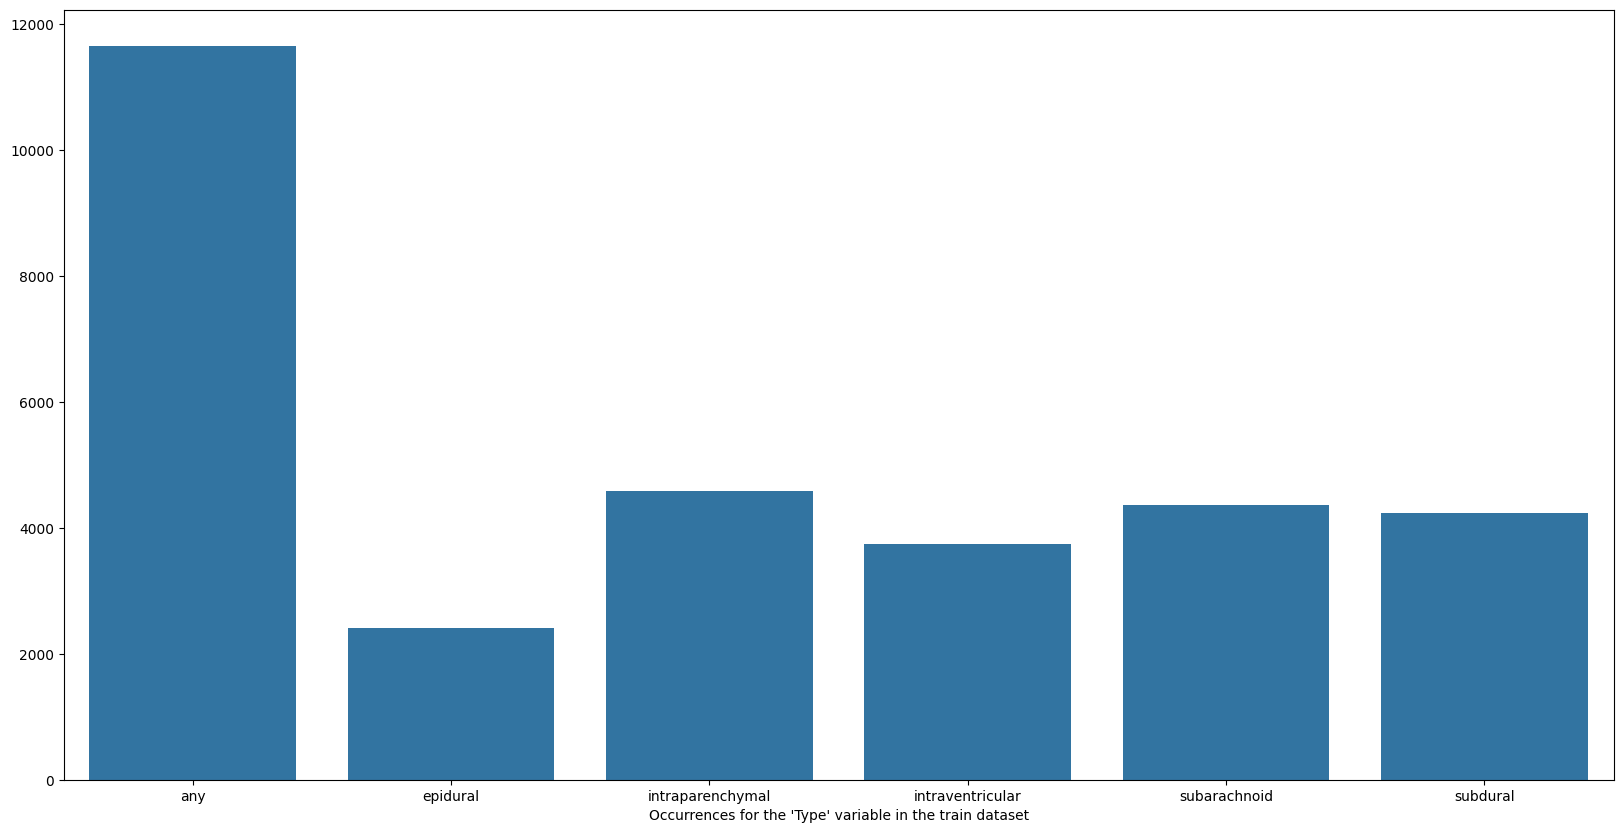

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTrain2.df[hemDatTrain2.df['Label']==1]['Type'], return_counts=True)
print(val, cnt)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in the train dataset")
sns.barplot(x=val, y=cnt)
plt.show()

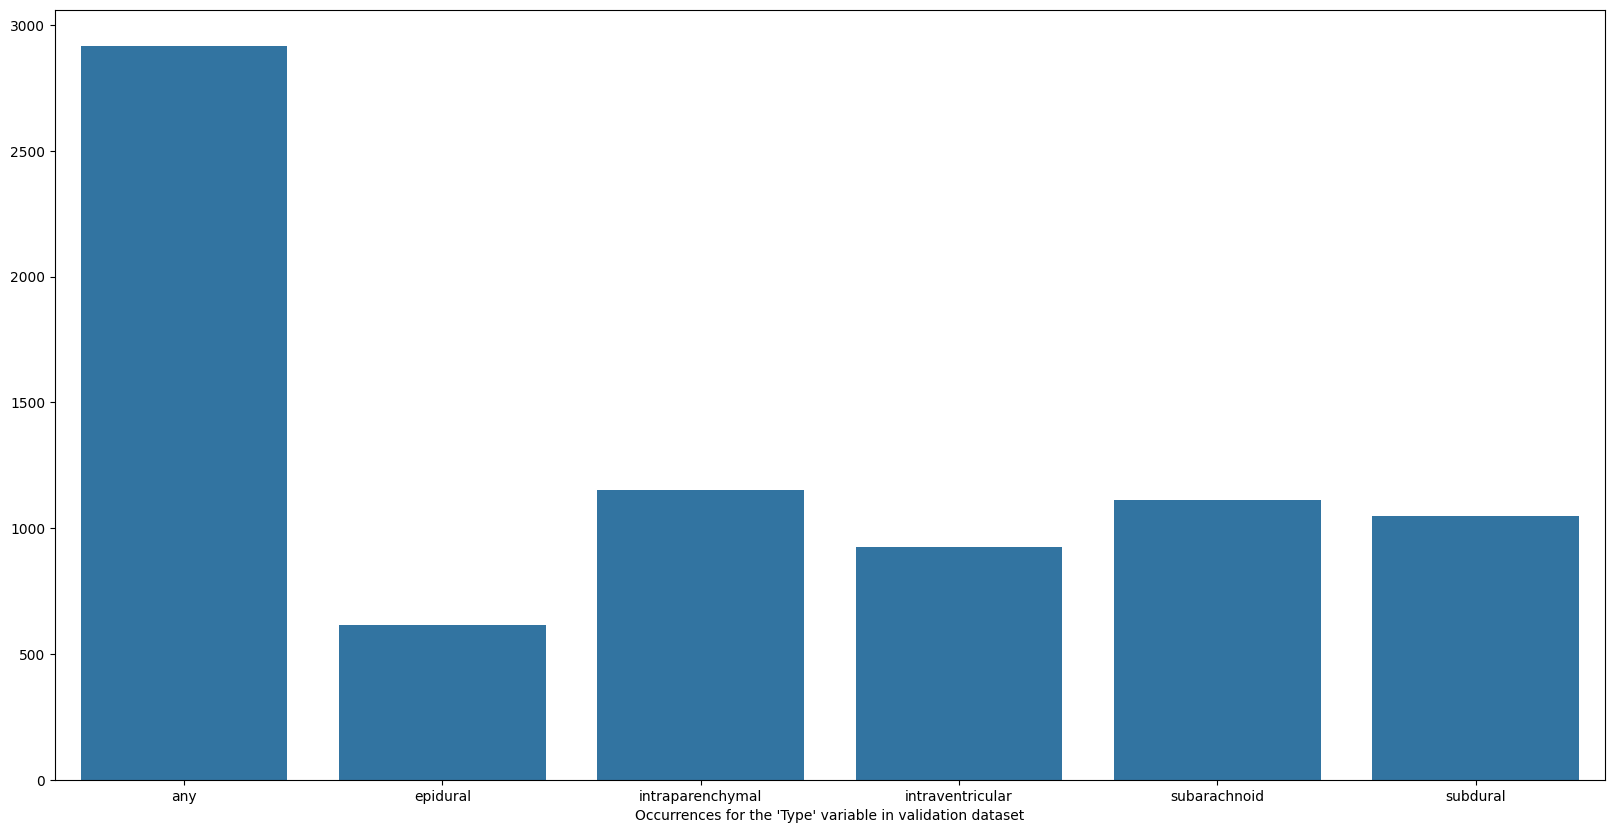

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatVal.df[hemDatVal.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in validation dataset")
sns.barplot(x=val, y=cnt)
plt.show()

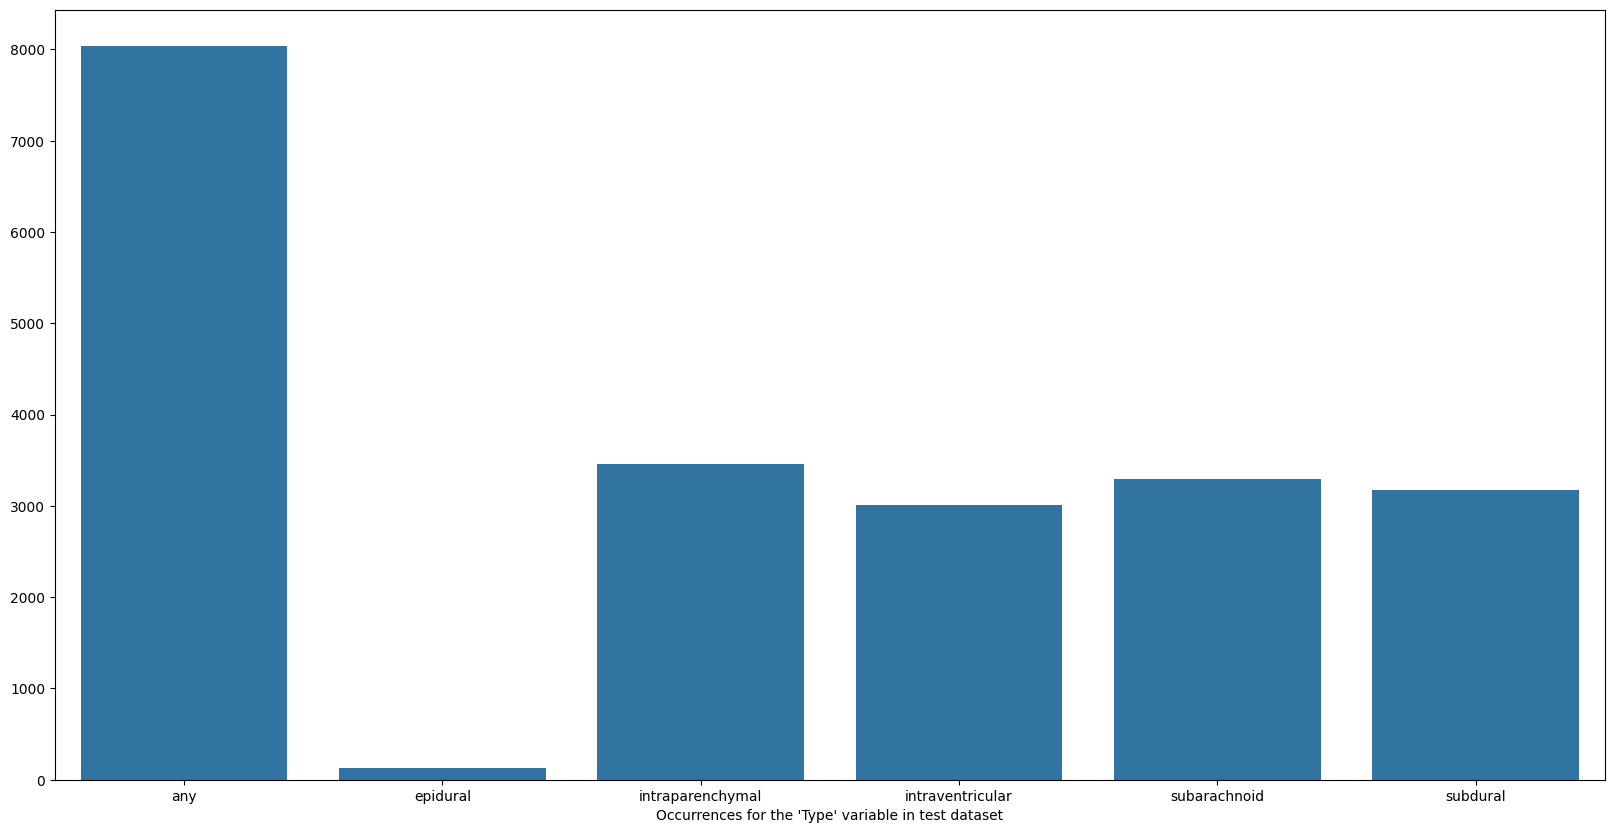

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTest.df[hemDatTest.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in test dataset")
sns.barplot(x=val, y=cnt)
plt.show()

It is obvious that the 'any' variable dominates in the train, validation and test datasets, because it represents whether the other variables are present within an image. In the train and validation dataset, the other variables are not balanced, because the least present variable ('epidural') represents approximately half of the occurrences of the most present variable ('intraparenchymal').

But in the test dataset, 'epidural' is almost non-existant, while have normal proportions.

We could use to handle imbalanced augmentation techniques, SMOTE, oversampling, undersampling or genetic algorithms, which help alleviate this.
We chose to go with the augmentation techniques, which involves

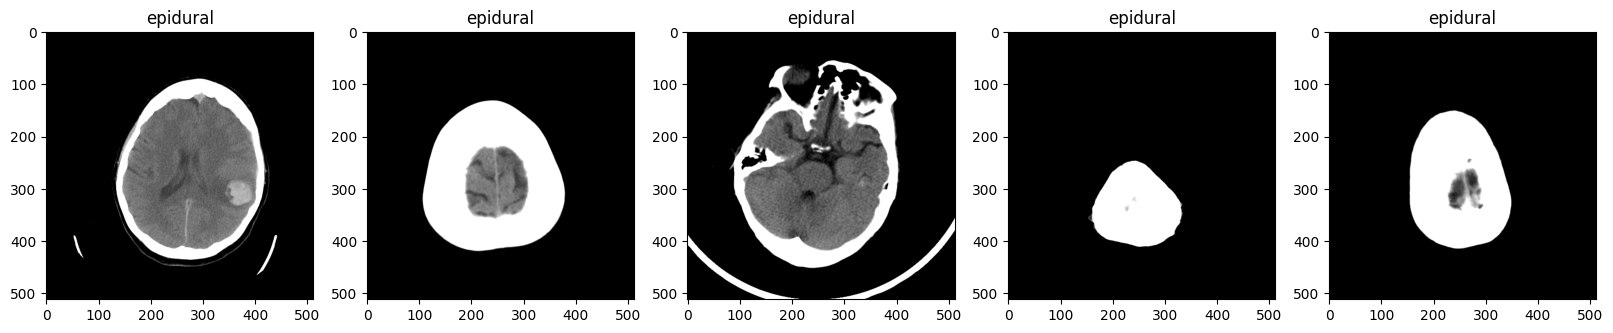

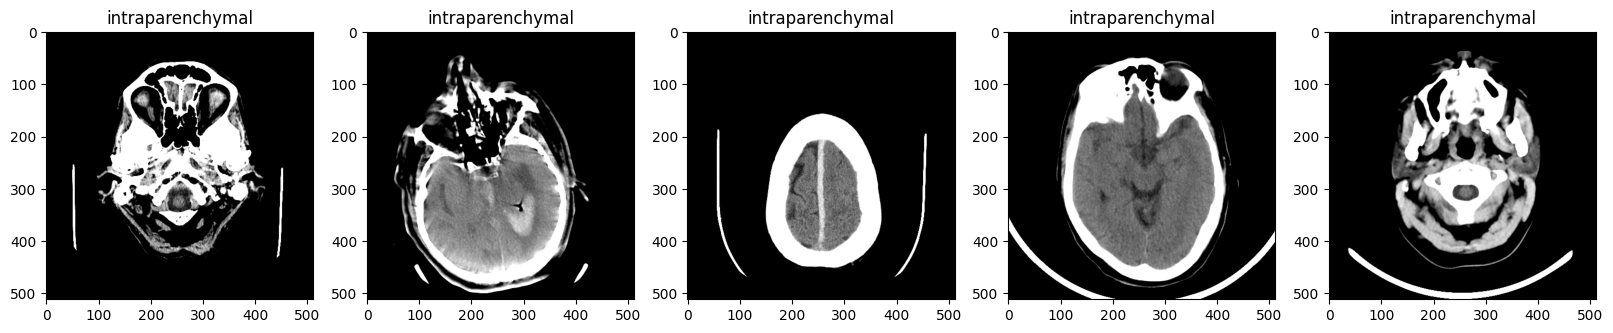

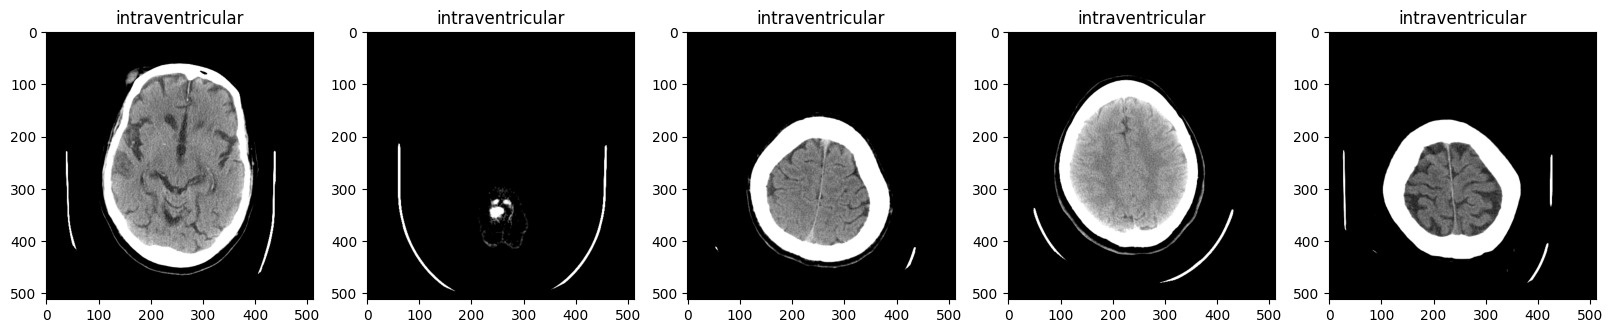

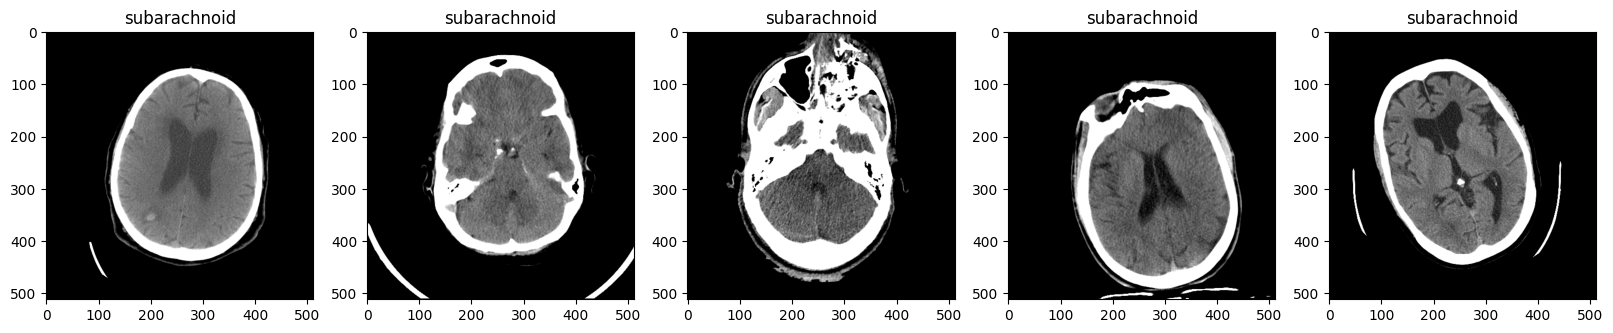

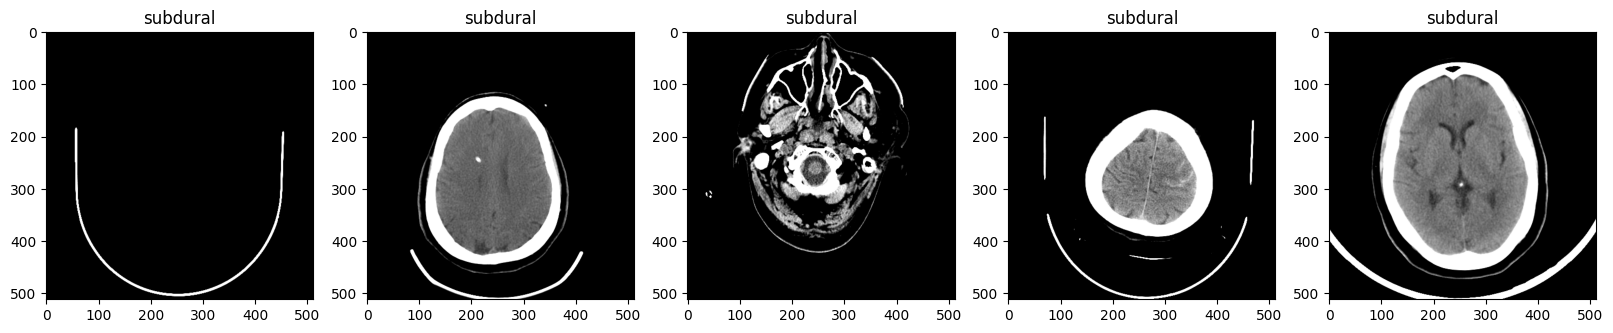

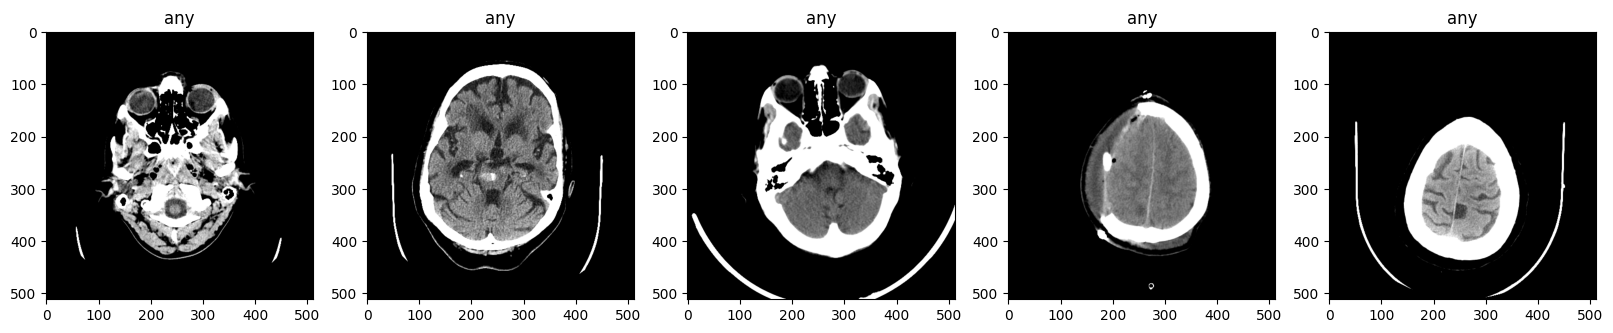

In [15]:
# TODO
import random
num_slices = 10
for cols in hemDatTrain2.df['Type'].unique():
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    current_type_df = hemDatTrain2.df[hemDatTrain2.df['Type']==cols]
    current_type_df = current_type_df[current_type_df['Label']==1]
    elements_r = random.sample(range(len(current_type_df)), 5)
    

    for i,ax in enumerate(axes):
        ax.set_title(cols)
        ax.imshow(PIL.Image.open(hemDatTrain2.file_location[elements_r[i]]), cmap = 'gray')


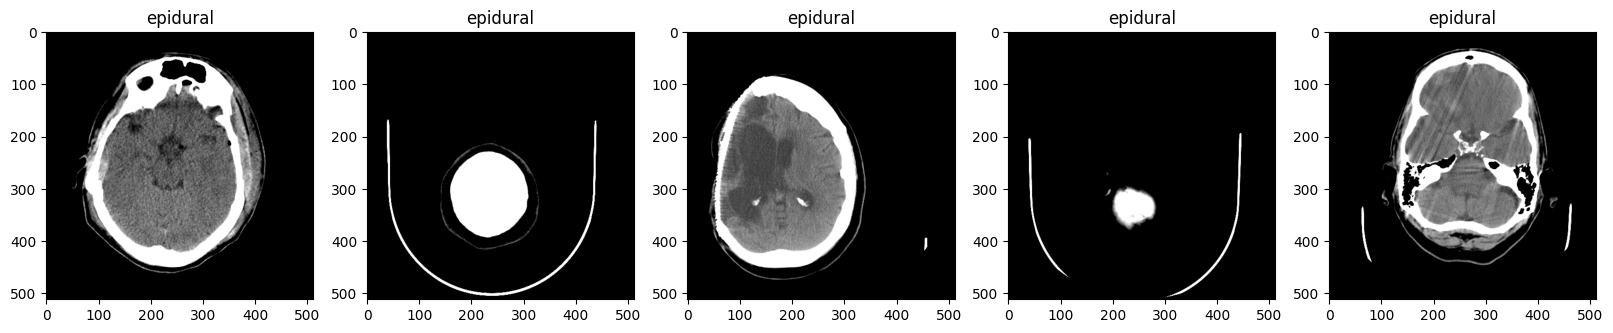

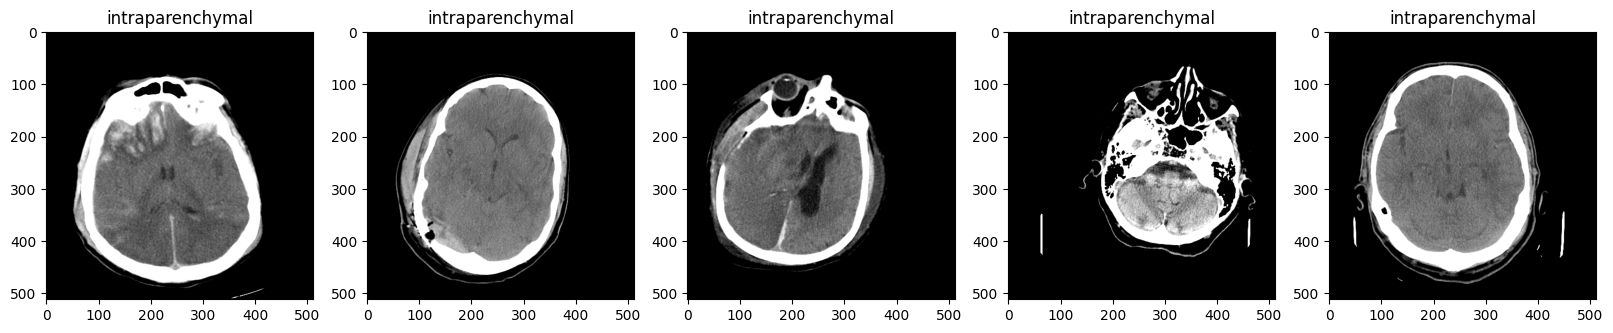

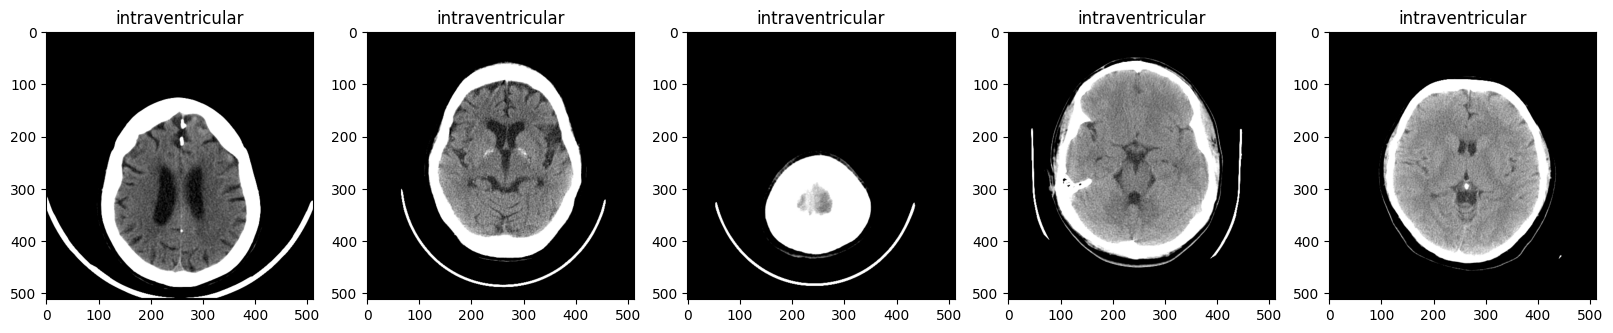

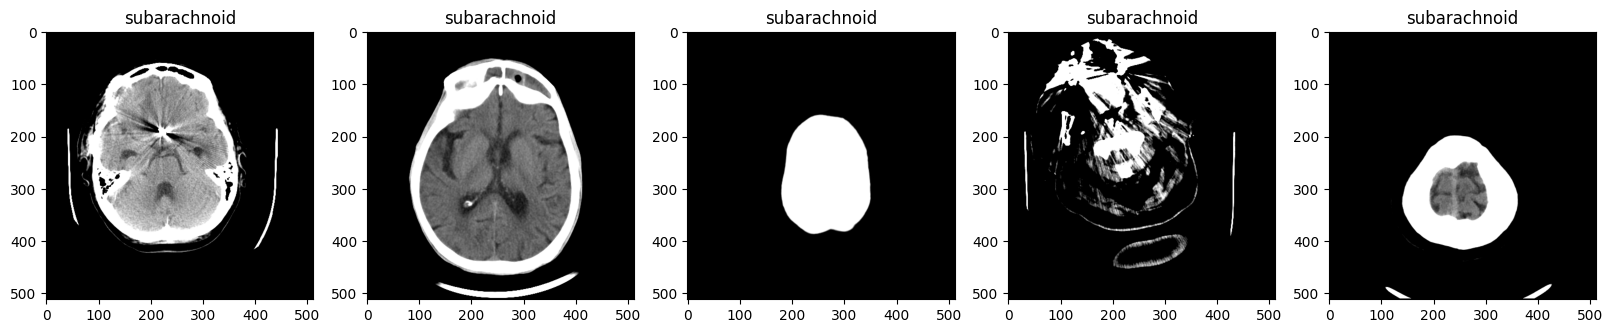

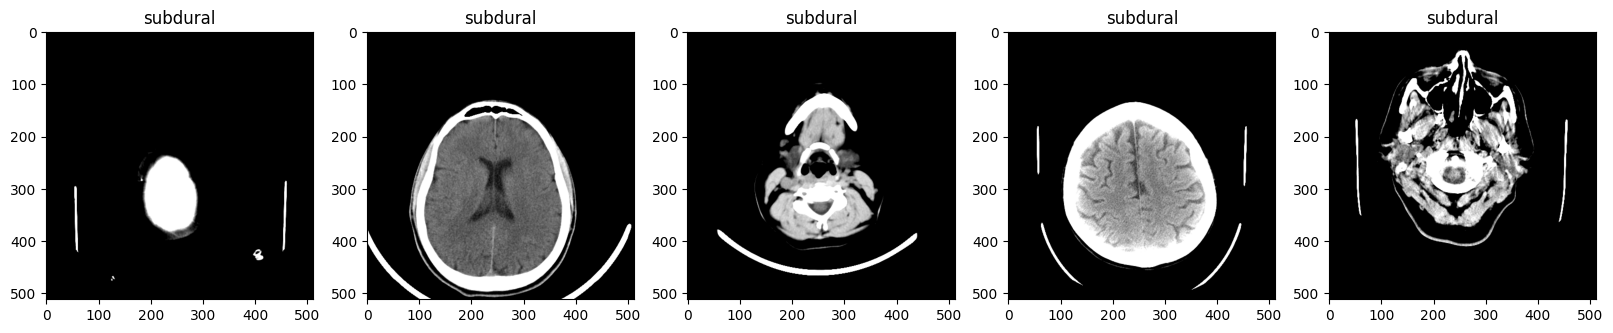

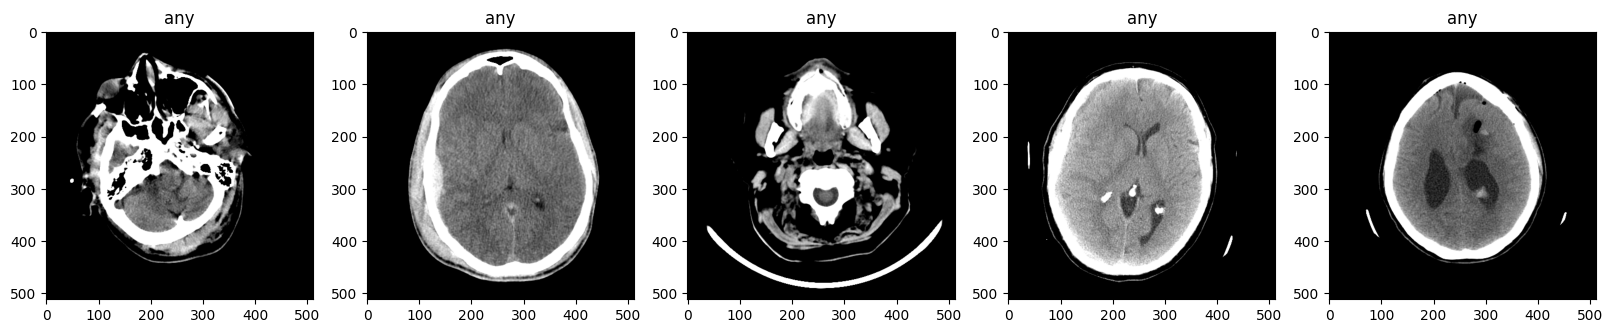

In [16]:
# TODO
import random
num_slices = 10
for cols in hemDatVal.df['Type'].unique():
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    current_type_df = hemDatVal.df[hemDatVal.df['Type']==cols]
    current_type_df = current_type_df[current_type_df['Label']==1]
    elements_r = random.sample(range(len(current_type_df)), 5)
    

    for i,ax in enumerate(axes):
        ax.set_title(cols)
        ax.imshow(PIL.Image.open(hemDatVal.file_location[elements_r[i]]), cmap = 'gray')


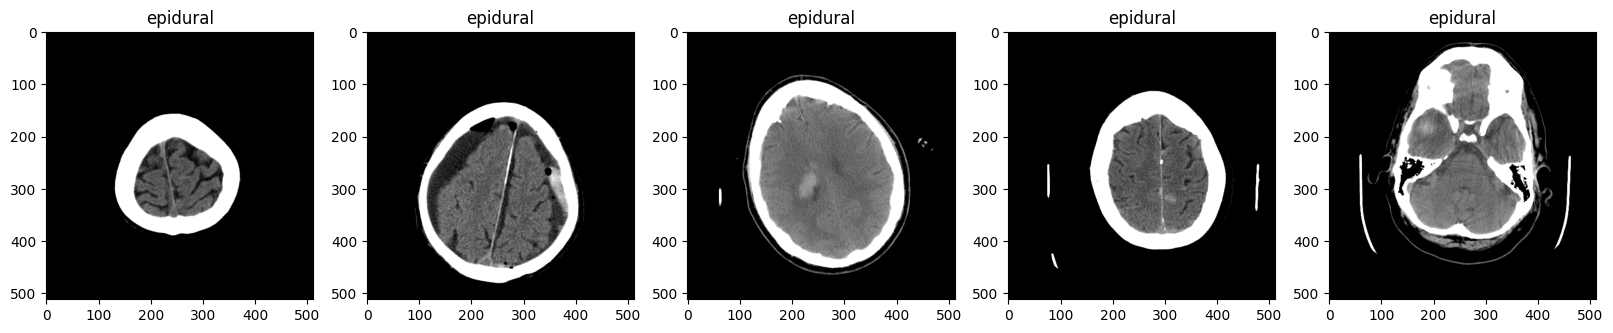

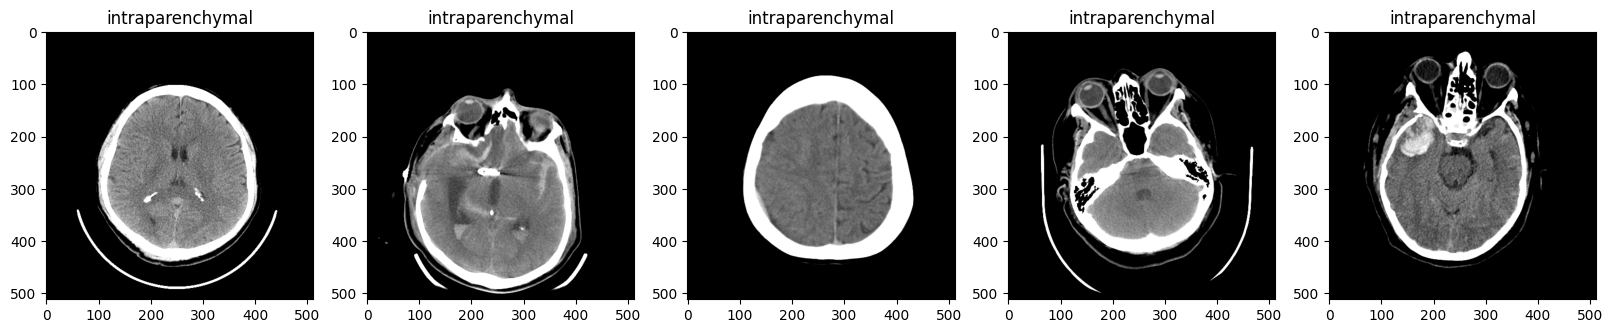

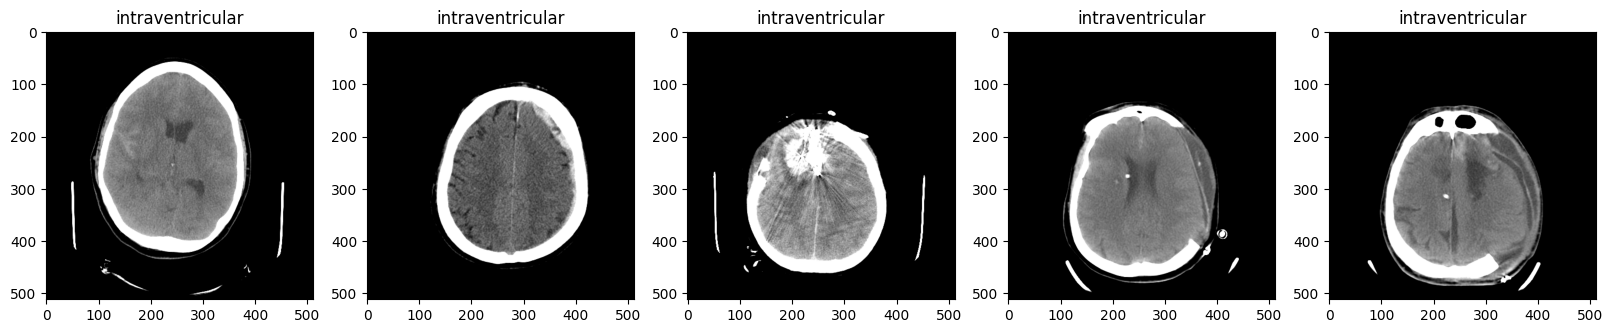

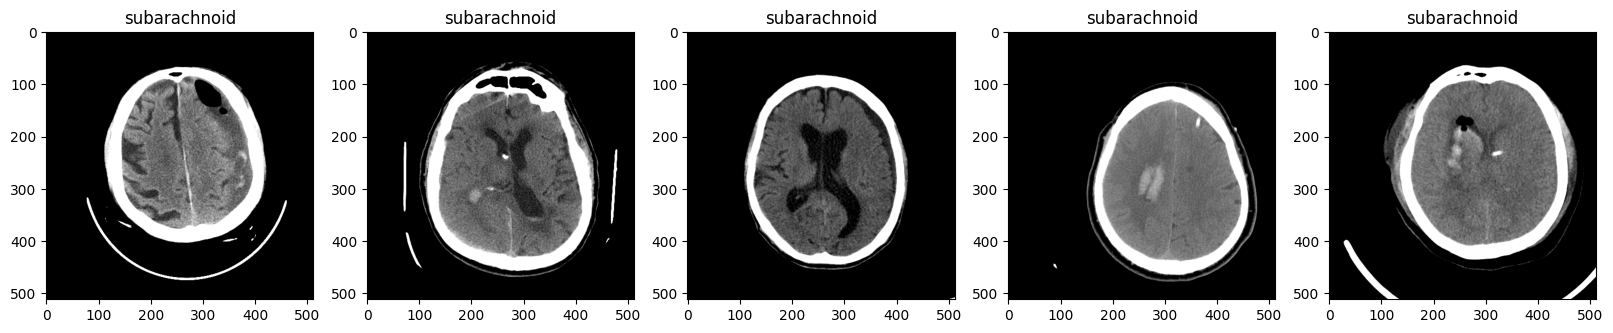

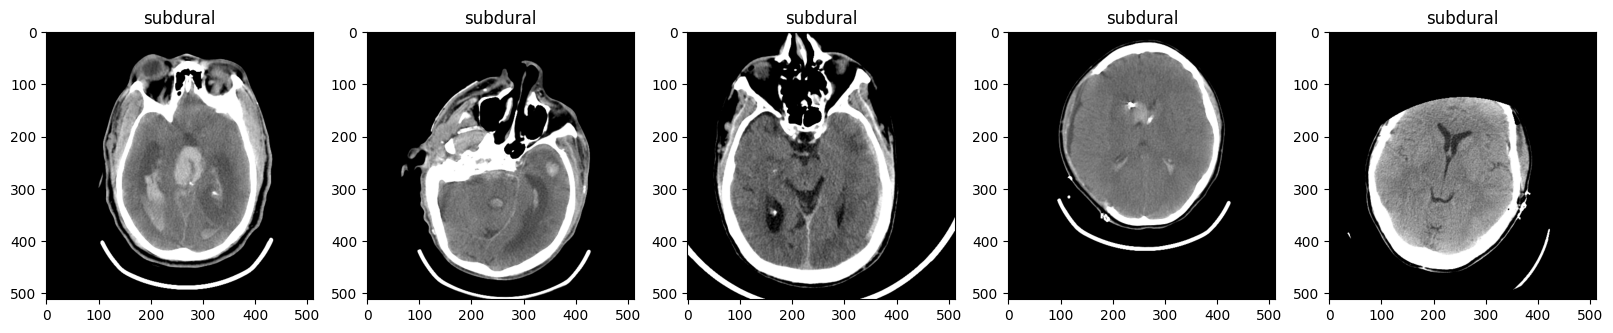

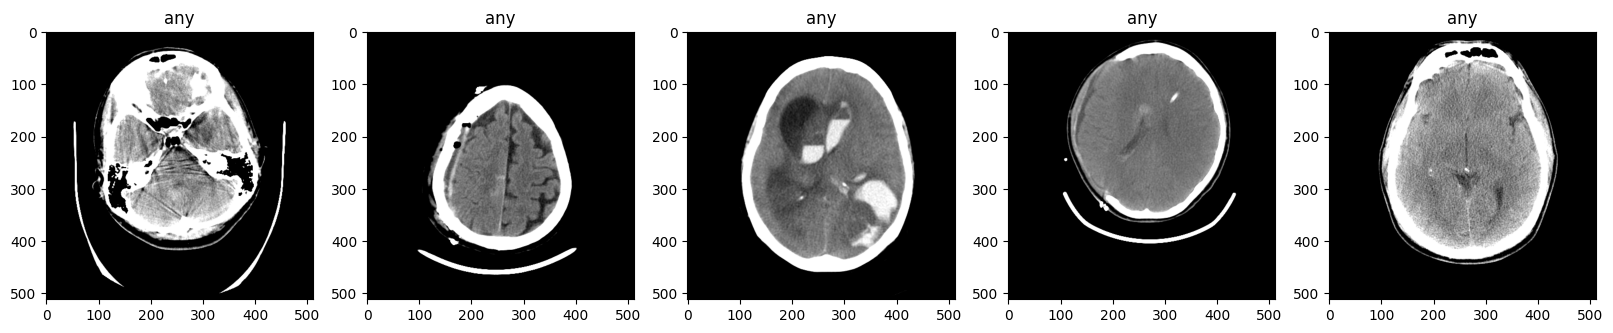

In [17]:
# TODO
import random
num_slices = 10
for cols in hemDatTest.df['Type'].unique():
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    current_type_df = hemDatTest.df[hemDatTest.df['Type']==cols]
    current_type_df = current_type_df[current_type_df['Label']==1]
    elements_r = random.sample(range(len(current_type_df)), 5)
    

    for i,ax in enumerate(axes):
        ax.set_title(cols)
        ax.imshow(PIL.Image.open(hemDatTest.file_location[elements_r[i]]), cmap = 'gray')


To examine more here

In [18]:
hemDatVal.most_common_size = (224, 224)
hemDatTest.most_common_size = (224, 224)
hemDatTrain2.most_common_size = (224, 224)


We later try to resize the images

We show the transformation for a random image from the train, test, val

In [19]:
val, cnt = np.unique(hemDatTrain2.df[hemDatTrain2.df['Label']==1]['Type'], return_counts=True)


In [20]:
from torch.utils.data import Subset
import operator
import torch

def augmentation_function(hemDatTrain2):
    hemDatTrain2_c =  Subset(hemDatTrain2, list(range(len(hemDatTrain2))))
    
    hemDatTrain2_c.file_location = hemDatTrain2.file_location
    hemDatTrain2_c.df = hemDatTrain2.df
    hemDatTrain2_c.transform = hemDatTrain2.transform
    hemDatTrain2_c.is_train = hemDatTrain2.is_train
    
    val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
    exclude_any_best_value = max(cnt[1:])
    exclude_any_best_value_index = np.argmax(cnt[1:])+1
    threshold = max(cnt) - min(cnt)
    
    while threshold > 400:
        for index_col in range(len(val)):
            if index_col == 0 or index_col == exclude_any_best_value_index:
                    continue
            different_elements = hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]
            different_elements= different_elements[different_elements['Type'] == val[index_col]]
            if exclude_any_best_value-cnt[index_col] == 0:
                continue
            elements_to_choose = random.sample(different_elements.index.to_list(), exclude_any_best_value-cnt[index_col])
            index_dif_el = list(map(lambda x: x//6, elements_to_choose))
            remaining_indices = list(set(different_elements.index.to_list()) - set(index_dif_el))
            f_l = operator.itemgetter(*index_dif_el)(hemDatTrain2_c.file_location.copy())
            list_elements = []
            
            for idx in index_dif_el:
                list_elements.extend(list(range(6*idx, 6*(idx+1))))
            our_df = pd.concat([hemDatTrain2_c.df.loc[list_elements, :]], ignore_index=True)
            our_transformed = operator.itemgetter(*index_dif_el)(hemDatTrain2_c.transform.copy())
            
            subset_dataset = Subset(hemDatTrain2_c, index_dif_el)
            my_final_list = hemDatTrain2_c.file_location.copy()
            Transforms = hemDatTrain2_c.transform.copy()
            
            df_og = hemDatTrain2_c.df
            
            hemDatTrain2_c = torch.utils.data.ConcatDataset([hemDatTrain2_c, subset_dataset])
            my_final_list.extend(f_l)
            
            hemDatTrain2_c.file_location = my_final_list
            
            our_df = pd.concat([df_og, our_df], ignore_index=True)
            hemDatTrain2_c.df = our_df
            
            
            Transforms.extend(our_transformed)
            
            hemDatTrain2_c.transform = Transforms
            hemDatTrain2_c.is_train = hemDatTrain2.is_train
        val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
        threshold = max(cnt[1:]) - min(cnt[1:])
        exclude_any_best_value = max(cnt[1:])
        exclude_any_best_value_index = np.argmax(cnt[1:])+1
    return hemDatTrain2_c



We try to balance the type, by inserting image augmentations, and we stop until the difference between the maximum and minimum is less than 200.

In [21]:
hemDatTrain2_c=augmentation_function(hemDatTrain_augmented2)

[20213  7136  7409  7172  7370  7267]


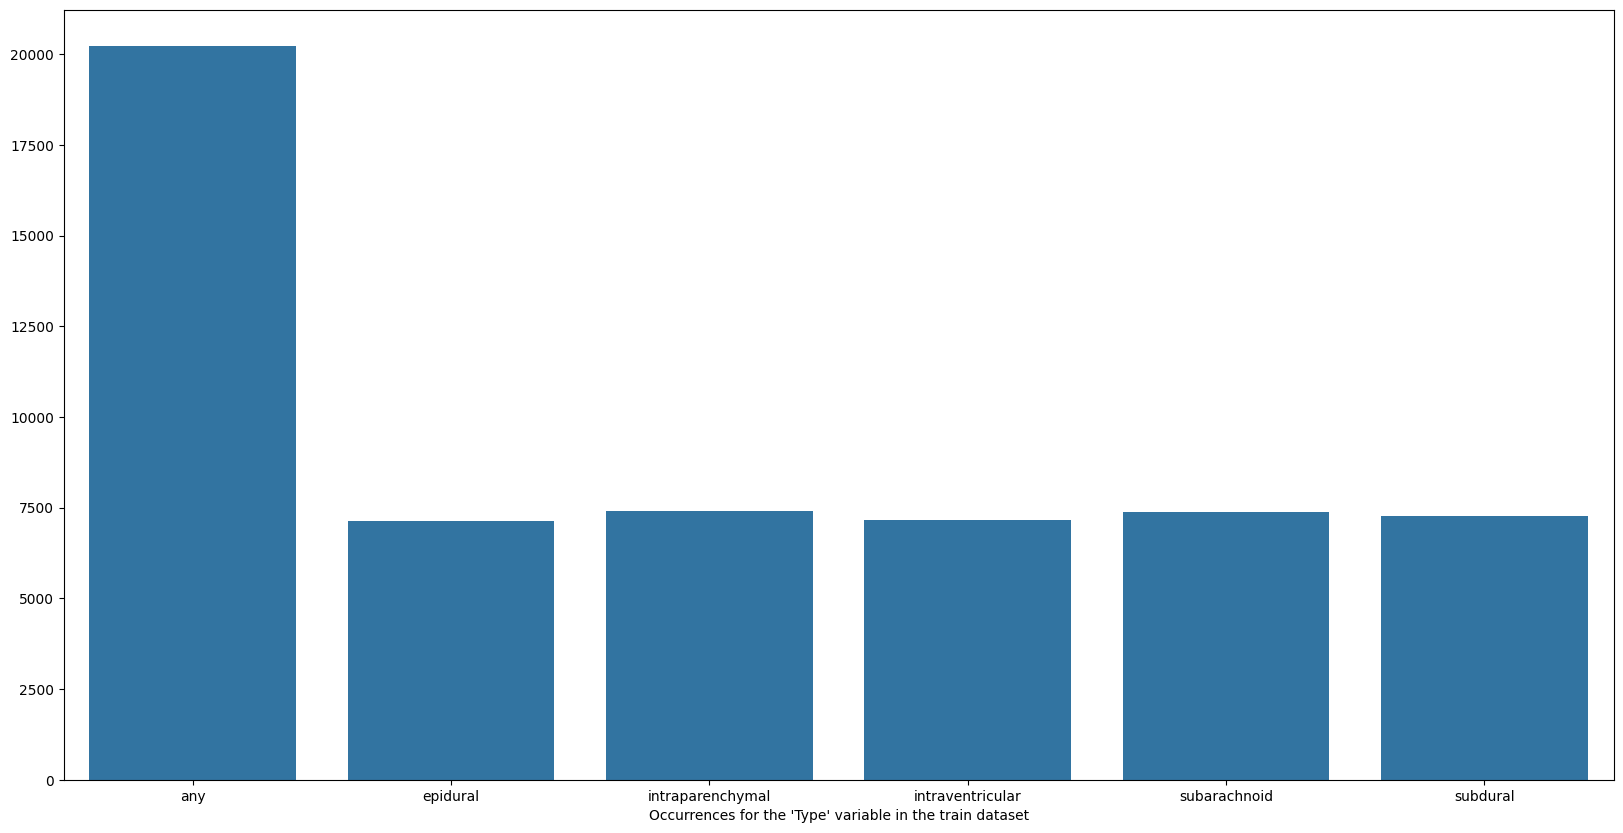

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))
print(cnt)
plt.xlabel(f"Occurrences for the 'Type' variable in the train dataset")
sns.barplot(x=val, y=cnt)
plt.show()

In [23]:
'''batch_size = 64
import torch
train_loader = torch.utils.data.DataLoader(hemDatTrain2_c, batch_size = batch_size, shuffle = True, num_workers=4)
val_loader = torch.utils.data.DataLoader(hemDatVal, batch_size = batch_size, shuffle = True, num_workers=4)
test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4)'''

'batch_size = 64\nimport torch\ntrain_loader = torch.utils.data.DataLoader(hemDatTrain2_c, batch_size = batch_size, shuffle = True, num_workers=4)\nval_loader = torch.utils.data.DataLoader(hemDatVal, batch_size = batch_size, shuffle = True, num_workers=4)\ntest_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4)'

In [24]:
'''val_shape = ()
out_shape = ()
for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
    for X, y in value:
        val_shape = X.shape
        out_shape = y.shape
        
        print(f"Shape of X : {X.shape}")    
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break'''

'val_shape = ()\nout_shape = ()\nfor key, value in {\'Training data\': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():\n    for X, y in value:\n        val_shape = X.shape\n        out_shape = y.shape\n        \n        print(f"Shape of X : {X.shape}")    \n        print(f"{key}:")\n        print(f"Shape of X : {X.shape}")\n        print(f"Shape of y: {y.shape} {y.dtype}\n")\n        break'

In [25]:
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
import torch.nn.functional as F

class FocalLoss(nn.Module):

    def __init__(self, alpha=0.25, gamma=0.25):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
       

    def forward(self, output, target):
        logpt = F.binary_cross_entropy_with_logits(output, target, reduction='none')
        pt = torch.exp(-logpt)
        alpha_t = self.alpha * target + (1-self.alpha) * (1-target)
        prob = alpha_t*(1-pt)**(self.gamma)*logpt
        return torch.mean(prob)

In [26]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None, scaler=None):

    use_amp = True

    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
        loss = loss_func(output, target)
        pred = (nn.Sigmoid()(output)>0.5).float()  # Get Output Class
        metric_b= (pred == target).all(dim=1).float().sum().item()

    if opt is not None:
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None, scaler=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt, scaler=scaler) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [27]:
from torchvision.models import resnet18, ResNet18_Weights,efficientnet_b4
model = resnet18(num_classes=6)
for name, layer in model.named_children():
    print(name)
    if name != 'fc':
        for param in layer.parameters():
            param.requires_grad = False
for name, layer in model.named_children():
    
    if name != 'fc':
        for param in layer.parameters():
            if param.requires_grad:
                print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [28]:
from tqdm.notebook import trange, tqdm
import time
time_current = None


def Train_Val(model, params,verbose=False, limit=False, s=None):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    early_stop_it = 0
    use_amp = True

    scaler = torch.amp.GradScaler("cuda", use_amp)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt, scaler=scaler)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        if (s!=None):
            global time_current
            time_current = time.time() - s


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl, scaler=scaler)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
            early_stop_it=0
        else:
            early_stop_it+=1

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*(val_metric):.2f}")
        print("-"*10)


        if limit and early_stop_it > 10:
            break
            
        

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history, best_model_wts

In [29]:
def Ture_and_Pred(val_loader, model, device):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        pred = (nn.Sigmoid()(outputs)>0.5).float()
        y_true.extend(labels)
        y_pred.extend(pred.detach().cpu())

    return y_true, y_pred

In [30]:
def get_pos_weights(df):
    weights_all = []
    for cols in df['Type'].unique():
        df_type = df[df['Type']==cols]
        num_neg = len(df_type[df_type['Label']==0])
        num_pos = len(df_type[df_type['Label']==1])
        weights = num_neg / (num_pos + 1e-5)
        weights_all.append(weights)
    return torch.as_tensor(weights_all)
num_weight = get_pos_weights(hemDatTrain2.df)

https://stackoverflow.com/questions/57021620/how-to-calculate-unbalanced-weights-for-bcewithlogitsloss-in-pytorch

In [31]:
list_ed = [0,1,2,3,4,5,6,7,8,9]

In [32]:
if len(hemDatTrain2.df) % 6 == 0:
    print("IS OKAY")

IS OKAY


In [33]:
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset

def get_sampler_pos_weight(df, num_weight):
    healthy_weight = max(torch.min(num_weight)*0.5,1.0)
    id_el = 0
    sampler_weights = []
    for id_name in df['ImageName'].unique():
        values = list(df[id_el:id_el+6]['Label'])
        if values.count(1) != 0:
            my_val = np.max([num_weight[i] * values[i] for i in range(len(values))])
            sampler_weights.append(my_val)
        else:
            sampler_weights.append(healthy_weight)
        
        id_el+=6
    return torch.as_tensor(sampler_weights)

    
    



In [34]:

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(df2)):
    val_min_index = val_index
    min_fold = fold
    train_min_index = train_index
    if fold == 0:
        break

Shape of X : torch.Size([32, 3, 224, 224])
Training data:
Shape of X : torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32, 6]) torch.float32

Shape of X : torch.Size([32, 3, 224, 224])
Validation data:
Shape of X : torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32, 6]) torch.float32

Shape of X : torch.Size([32, 3, 224, 224])
Test data:
Shape of X : torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32, 6]) torch.float32



  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0/15, current lr=0.0001
Copied best model weights!
train loss: 0.010468, dev loss: 0.009861, accuracy: 62.11
----------
Epoch 1/15, current lr=0.0001
train loss: 0.009140, dev loss: 0.010704, accuracy: 64.11
----------
Epoch 2/15, current lr=0.0001
Copied best model weights!
train loss: 0.008495, dev loss: 0.009571, accuracy: 48.12
----------
Epoch 3/15, current lr=0.0001
Copied best model weights!
train loss: 0.008012, dev loss: 0.007636, accuracy: 64.23
----------
Epoch 4/15, current lr=0.0001
Copied best model weights!
train loss: 0.007527, dev loss: 0.007430, accuracy: 64.13
----------
Epoch 5/15, current lr=0.0001
train loss: 0.007475, dev loss: 0.009657, accuracy: 66.79
----------
Epoch 6/15, current lr=0.0001
train loss: 0.007060, dev loss: 0.007704, accuracy: 59.19
----------
Epoch 7/15, current lr=0.0001
Loading best model weights!
train loss: 0.006626, dev loss: 0.007503, accuracy: 65.79
----------
Epoch 8/15, current lr=5e-05
Copied best model weights!
train loss: 0.00

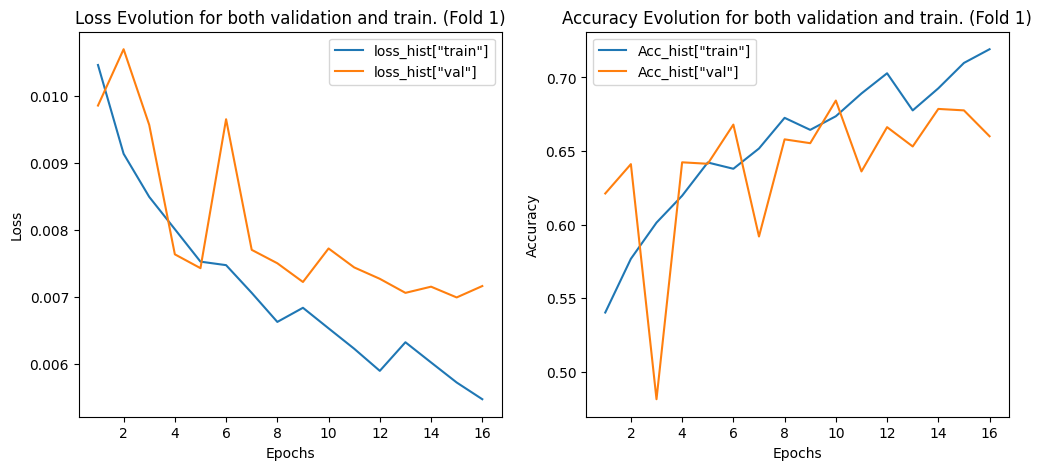

In [35]:
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
from torchvision.models import resnet18, ResNet18_Weights,efficientnet_b4
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score,  roc_auc_score, accuracy_score, hamming_loss
import statistics
import statistics
from prettytable import PrettyTable
import copy
metric_hist_list = []
loss_hist_list = []
resnet_model_list = []
best_model_wts_list = []
min_worst_f1_score2 = float('inf')
min_iteration = -1
max_best_f1_score2 = -float('inf')
max_iteration = -1
auc_list3 = []
accuracy_score_list3 = []
precision_list3 = []
recall_list3 = []
f1_score_list3 = []

auc_list4 = []
accuracy_score_list4 = []
hamming_lost_list3 = []
hamming_lost_list4 = []

precision_list4 = []
recall_list4 = []
f1_score_list4 = []

metric_hist_list2 = []
loss_hist_list2 = []
resnet_model_list2 = []
best_model_wts_list2 = []
time_list = []
import time


for index_val in range(1):

    s = time.time()
    cnn_model = resnet18(weights=None)

    num_ftrs = cnn_model.fc.in_features
    cnn_model.fc = nn.Linear(num_ftrs, 6)

    if index_val == 0:
        cnn_model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, 6)
        )
    if torch.cuda.is_available():
        cnn_model.cuda()
    if torch.cuda.device_count() > 1: 
        cnn_model = nn.DataParallel(cnn_model)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    cnn_model.to(device)
    X_train = df2.loc[train_min_index]
    X_test = df2.loc[val_min_index]
    val_index2 = val_index
    files_with_train = X_train['Image'].to_list()
    files_with_val = X_val['Image'].to_list()
    files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
    files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))
    df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
    df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
    df_Val = pd.concat([df_Val], ignore_index=True)
    df_Train = pd.concat([df_Train], ignore_index=True)


    hemDatTrain3 = HemorrhageDataset(files_train, df_Train, special_transform, True, True)
       
    hemDatVal2 = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)
    
  
    batch_size = 32
    
    num_weight = get_pos_weights(hemDatTrain3.df)
    sampler_pos_weight = get_sampler_pos_weight(hemDatTrain3.df, num_weight)
    num_weight = num_weight.to(device)
    sampler = WeightedRandomSampler(sampler_pos_weight, len(sampler_pos_weight))
    train_loader = None
  
    train_loader = torch.utils.data.DataLoader(hemDatTrain3, sampler=sampler, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(hemDatVal2, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    
    val_shape = ()
    out_shape = ()
    for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
        for X, y in value:
            val_shape = X.shape
            out_shape = y.shape
            
            print(f"Shape of X : {X.shape}")    
            print(f"{key}:")
            print(f"Shape of X : {X.shape}")
            print(f"Shape of y: {y.shape} {y.dtype}\n")
            break
    
    loss_function = torch.nn.BCEWithLogitsLoss()


    optimizer = optim.Adam(cnn_model.parameters(),lr=1e-4, weight_decay=1e-4)
       

    
    params_train={
     "train": train_loader,"val": val_loader,
     "epochs": 16,   
     "optimiser": optimizer,
     "lr_change": ReduceLROnPlateau(optimizer,
                                        mode='min',
                                        factor=0.5,
                                        patience=2),
     "f_loss": loss_function,
     "weight_path": "weights.pt",
    }

    resnet_model,loss_hist,metric_hist,best_model_wts = Train_Val(cnn_model,params_train, verbose=True, limit=True, s=s)

    time_current2 = f"{time_current//3600} h {(time_current - (time_current//3600)*3600)//60} minutes {time_current-(time_current//3600)*3600-((time_current - (time_current//3600)*3600)//60)*60} seconds"
    time_list.append(time_current2)
    
    metric_hist_list2.append(metric_hist)
    loss_hist_list2.append(loss_hist)
    resnet_model_list2.append(resnet_model)
    best_model_wts_list2.append(best_model_wts)

    for idx, (train, val) in enumerate(zip(metric_hist['train'], metric_hist['val'])):
        print(f"Iteration {idx}. Accurracy for train :{train*100}. Accurracy for val :{val*100}")
    for idx, (train, val) in enumerate(zip(loss_hist['train'], loss_hist['val'])):
        print(f"Iteration {idx}. Loss for train :{train}. Loss for val :{val}")


    # Convergence History Plot
    epochs=params_train["epochs"]
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    list_metric_train = list(map(lambda x: x, metric_hist["train"]))
    list_metric_val = list(map(lambda x: x, metric_hist["val"]))
    
    sns.lineplot(x=[*range(1,len(loss_hist["train"])+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
    sns.lineplot(x=[*range(1,len(loss_hist["val"])+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')

    ax[0].set_title(f"Loss Evolution for both validation and train. (Fold {fold+1})")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    
    sns.lineplot(x=[*range(1,len(metric_hist["train"])+1)],y=list_metric_train,ax=ax[1],label='Acc_hist["train"]')
    sns.lineplot(x=[*range(1,len(metric_hist["val"])+1)],y=list_metric_val,ax=ax[1],label='Acc_hist["val"]')
    ax[1].set_title(f"Accuracy Evolution for both validation and train. (Fold {fold+1})")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    

    print("Time for training ", time_current2)
    loss_func = torch.nn.BCEWithLogitsLoss()
    y_true, y_pred = Ture_and_Pred(test_loader, resnet_model, device)

    metric_b=roc_auc_score(y_pred, y_true)
    accuracy_s = accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    _hamming = hamming_loss(y_true, y_pred)
    auc_list3.append(_acc)
    precision_list3.append(_precision)
    recall_list3.append(_recall)
    f1_score_list3.append(_f1_score)
    accuracy_score_list3.append(accuracy_s)
    hamming_lost_list3.append(_hamming)

    
    print(f"For test:\n auc:{metric_b}\n accuracy:{accuracy_s}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n hamming score:{1-_hamming}\n")

    if _f1_score < min_worst_f1_score2:
        min_worst_f1_score2 = _f1_score
        min_iteration = index_val



    if _f1_score > max_best_f1_score2:
        max_best_f1_score = _f1_score
        max_iteration = index_val


    y_true, y_pred = Ture_and_Pred(val_loader, resnet_model, device)

    metric_b=roc_auc_score(y_pred, y_true)
    accuracy_s = accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    _hamming = hamming_loss(y_true, y_pred)

    auc_list4.append(_acc)
    precision_list4.append(_precision)
    recall_list4.append(_recall)
    f1_score_list4.append(_f1_score)
    accuracy_score_list4.append(accuracy_s)
    hamming_lost_list4.append(_hamming)


    
    print(f"For validation:\n auc:{metric_b}\n accuracy:{accuracy_s}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n hamming score:{1-_hamming}\n")

   



    

Shape of X : torch.Size([32, 3, 224, 224])
Training data:
Shape of X : torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32, 6]) torch.float32

Shape of X : torch.Size([32, 3, 224, 224])
Validation data:
Shape of X : torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32, 6]) torch.float32

Shape of X : torch.Size([32, 3, 224, 224])
Test data:
Shape of X : torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32, 6]) torch.float32



  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0/15, current lr=0.0001
Copied best model weights!
train loss: 0.010242, dev loss: 0.009848, accuracy: 63.90
----------
Epoch 1/15, current lr=0.0001
Copied best model weights!
train loss: 0.008902, dev loss: 0.009189, accuracy: 63.28
----------
Epoch 2/15, current lr=0.0001
Copied best model weights!
train loss: 0.008172, dev loss: 0.008529, accuracy: 66.01
----------
Epoch 3/15, current lr=0.0001
Copied best model weights!
train loss: 0.007735, dev loss: 0.007773, accuracy: 64.38
----------
Epoch 4/15, current lr=0.0001
train loss: 0.007335, dev loss: 0.007942, accuracy: 66.63
----------
Epoch 5/15, current lr=0.0001
train loss: 0.007019, dev loss: 0.008663, accuracy: 53.34
----------
Epoch 6/15, current lr=0.0001
train loss: 0.006636, dev loss: 0.009241, accuracy: 56.46
----------
Epoch 7/15, current lr=0.0001
Copied best model weights!
train loss: 0.006298, dev loss: 0.007729, accuracy: 64.60
----------
Epoch 8/15, current lr=0.0001
Copied best model weights!
train loss: 0.00

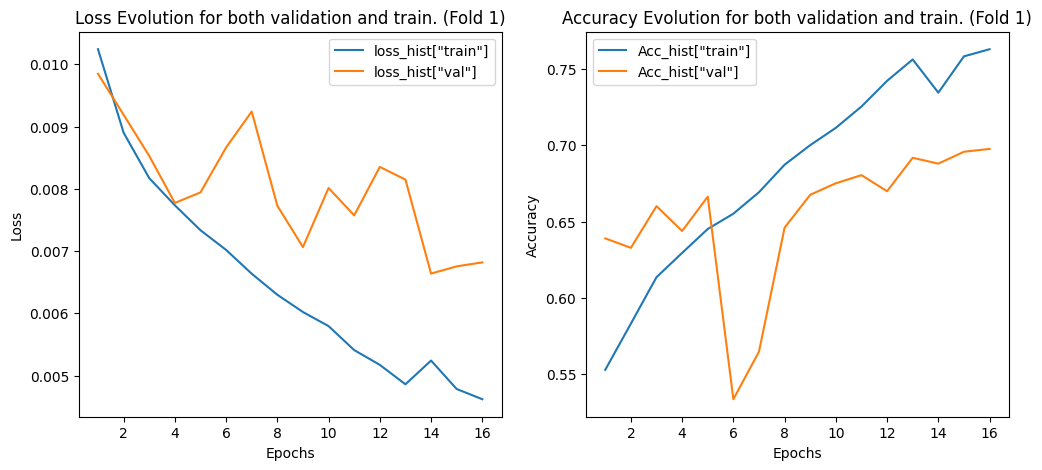

In [38]:
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
from torchvision.models import resnet18, ResNet18_Weights,efficientnet_b4
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score,  roc_auc_score, accuracy_score, hamming_loss
import statistics
import statistics
from prettytable import PrettyTable
import copy
import time


for index_val in range(1):

    s = time.time()
    cnn_model = resnet18(weights=None)

    num_ftrs = cnn_model.fc.in_features
    cnn_model.fc = nn.Linear(num_ftrs, 6)

    
    if torch.cuda.is_available():
        cnn_model.cuda()
    if torch.cuda.device_count() > 1: 
        cnn_model = nn.DataParallel(cnn_model)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    cnn_model.to(device)
    X_train = df2.loc[train_min_index]
    X_test = df2.loc[val_min_index]
    val_index2 = val_index
    files_with_train = X_train['Image'].to_list()
    files_with_val = X_val['Image'].to_list()
    files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
    files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))
    df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
    df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
    df_Val = pd.concat([df_Val], ignore_index=True)
    df_Train = pd.concat([df_Train], ignore_index=True)


    hemDatTrain3 = HemorrhageDataset(files_train, df_Train, special_transform, True, True)
       
    hemDatVal2 = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)
    
  
    batch_size = 32
    
    num_weight = get_pos_weights(hemDatTrain3.df)
    sampler_pos_weight = get_sampler_pos_weight(hemDatTrain3.df, num_weight)
    num_weight = num_weight.to(device)
    sampler = WeightedRandomSampler(sampler_pos_weight, len(sampler_pos_weight))
    train_loader = None
  
    train_loader = torch.utils.data.DataLoader(hemDatTrain3, sampler=sampler, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(hemDatVal2, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
    
    val_shape = ()
    out_shape = ()
    for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
        for X, y in value:
            val_shape = X.shape
            out_shape = y.shape
            
            print(f"Shape of X : {X.shape}")    
            print(f"{key}:")
            print(f"Shape of X : {X.shape}")
            print(f"Shape of y: {y.shape} {y.dtype}\n")
            break
    
    loss_function = torch.nn.BCEWithLogitsLoss()


    optimizer = optim.Adam(cnn_model.parameters(),lr=1e-4, weight_decay=1e-4)
       

    
    params_train={
     "train": train_loader,"val": val_loader,
     "epochs": 16,   
     "optimiser": optimizer,
     "lr_change": ReduceLROnPlateau(optimizer,
                                        mode='min',
                                        factor=0.1,
                                        patience=3),
     "f_loss": loss_function,
     "weight_path": "weights.pt",
    }

    resnet_model,loss_hist,metric_hist,best_model_wts = Train_Val(cnn_model,params_train, verbose=True, limit=True, s=s)

    time_current2 = f"{time_current//3600} h {(time_current - (time_current//3600)*3600)//60} minutes {time_current-(time_current//3600)*3600-((time_current - (time_current//3600)*3600)//60)*60} seconds"
    time_list.append(time_current2)
    
    metric_hist_list2.append(metric_hist)
    loss_hist_list2.append(loss_hist)
    resnet_model_list2.append(resnet_model)
    best_model_wts_list2.append(best_model_wts)

    for idx, (train, val) in enumerate(zip(metric_hist['train'], metric_hist['val'])):
        print(f"Iteration {idx}. Accurracy for train :{train*100}. Accurracy for val :{val*100}")
    for idx, (train, val) in enumerate(zip(loss_hist['train'], loss_hist['val'])):
        print(f"Iteration {idx}. Loss for train :{train}. Loss for val :{val}")


    # Convergence History Plot
    epochs=params_train["epochs"]
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    list_metric_train = list(map(lambda x: x, metric_hist["train"]))
    list_metric_val = list(map(lambda x: x, metric_hist["val"]))
    
    sns.lineplot(x=[*range(1,len(loss_hist["train"])+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
    sns.lineplot(x=[*range(1,len(loss_hist["val"])+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')

    ax[0].set_title(f"Loss Evolution for both validation and train. (Fold {fold+1})")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    
    sns.lineplot(x=[*range(1,len(metric_hist["train"])+1)],y=list_metric_train,ax=ax[1],label='Acc_hist["train"]')
    sns.lineplot(x=[*range(1,len(metric_hist["val"])+1)],y=list_metric_val,ax=ax[1],label='Acc_hist["val"]')
    ax[1].set_title(f"Accuracy Evolution for both validation and train. (Fold {fold+1})")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    

    print("Time for training ", time_current2)
    loss_func = torch.nn.BCEWithLogitsLoss()
    y_true, y_pred = Ture_and_Pred(test_loader, resnet_model, device)

    metric_b=roc_auc_score(y_pred, y_true)
    accuracy_s = accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    _hamming = hamming_loss(y_true, y_pred)
    auc_list3.append(_acc)
    precision_list3.append(_precision)
    recall_list3.append(_recall)
    f1_score_list3.append(_f1_score)
    accuracy_score_list3.append(accuracy_s)
    hamming_lost_list3.append(_hamming)

    
    print(f"For test:\n auc:{metric_b}\n accuracy:{accuracy_s}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n hamming score:{1-_hamming}\n")

    if _f1_score < min_worst_f1_score2:
        min_worst_f1_score2 = _f1_score
        min_iteration = index_val



    if _f1_score > max_best_f1_score2:
        max_best_f1_score = _f1_score
        max_iteration = index_val


    y_true, y_pred = Ture_and_Pred(val_loader, resnet_model, device)

    metric_b=roc_auc_score(y_pred, y_true)
    accuracy_s = accuracy_score(y_pred, y_true)
    _acc = metric_b
    _f1_score = f1_score(y_true, y_pred, average='macro')
    _recall = recall_score(y_true, y_pred, average='macro')
    _precision = precision_score(y_true, y_pred, average='macro')
    _hamming = hamming_loss(y_true, y_pred)

    auc_list4.append(_acc)
    precision_list4.append(_precision)
    recall_list4.append(_recall)
    f1_score_list4.append(_f1_score)
    accuracy_score_list4.append(accuracy_s)
    hamming_lost_list4.append(_hamming)


    
    print(f"For validation:\n auc:{metric_b}\n accuracy:{accuracy_s}\n precision:{_precision}\n recall:{_recall}\n f1_score:{_f1_score}\n hamming score:{1-_hamming}\n")

   



    

In [45]:
import statistics
from prettytable import PrettyTable 
print("For test set:")
table = PrettyTable(["Column ","AUC", "Hamming Score", "Accuracy", "F1-score", "Precision", "Recall"]) 

for i in range(2):
    str_column = ""
   

    if i==0:
        str_column = "Dropout (p=0.5)"
    elif i==1:
        str_column = "ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=3)"
    



    table.add_row([str_column, auc_list3[i], 1-hamming_lost_list3[i], accuracy_score_list3[i], f1_score_list3[i], precision_list3[i], recall_list3[i]]) 
print(table) 

For test set:
+---------------------------------------------------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|                            Column                             |        AUC         |   Hamming Score    |       Accuracy      |      F1-score      |     Precision      |       Recall       |
+---------------------------------------------------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|                        Dropout (p=0.5)                        | 0.7132056498151244 | 0.8044724126306326 |  0.3083492527250253 | 0.5737150419321967 | 0.6918064858340807 | 0.5456487701464638 |
| ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=3) | 0.7269120173284535 | 0.8205603625875566 | 0.33711652994718505 | 0.612711861326983  | 0.7008212918243828 | 0.5834582318333655 |
+--------------------

In [46]:
import statistics
from prettytable import PrettyTable 
print("For validation set:")
table = PrettyTable(["Column ","AUC", "Hamming Score", "Accuracy", "F1-score", "Precision", "Recall"]) 

for i in range(2):
    str_column = ""
    
    if i==0:
        str_column = "Dropout (p=0.5)"
    elif i==1:
        str_column = "ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=3)"
       
    table.add_row([str_column, auc_list4[i],1-hamming_lost_list4[i], accuracy_score_list4[i], f1_score_list4[i], precision_list4[i], recall_list4[i]]) 
print(table) 

For validation set:
+---------------------------------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|                            Column                             |        AUC         |   Hamming Score    |      Accuracy      |      F1-score      |     Precision      |       Recall      |
+---------------------------------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|                        Dropout (p=0.5)                        | 0.8313177471618859 | 0.9104819724941148 | 0.6776112005947218 | 0.6148118493834277 | 0.7356832990816531 | 0.595194459923586 |
| ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=3) | 0.8350151488750699 | 0.9161194399702639 | 0.6880188328583818 | 0.6531372990483234 | 0.7343008318350145 | 0.595194459923586 |
+------------------------